# Proyek Klasifikasi Gambar: [Dog vs Cat]
- **Nama:** [Firman Fitrah Ramadhan]
- **Email:** [firmanfitrahramadhan38@gmail.com]
- **ID Dicoding:** [firman_fitrah_ramadhan_XNq4]

Dataset kaggle: https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat

## Import Semua Packages/Library yang Digunakan

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import kagglehub
import os
import shutil
import random

## Data Preparation

In [2]:
path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")
print("📥 Dataset downloaded to:", path)

dest = "model-datasets"
os.makedirs(dest, exist_ok=True)

for item in os.listdir(path):
    src_path = os.path.join(path, item)
    dest_path = os.path.join(dest, item)

    if os.path.isdir(src_path):
        shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
    else:
        shutil.copy2(src_path, dest_path)

print(f"✅ Dataset copied to: {os.path.abspath(dest)}")

train_dir = os.path.join(dest, 'train')
val_dir = os.path.join(dest, 'val')
test_dir = os.path.join(dest, 'test')

📥 Dataset downloaded to: /kaggle/input/dog-vs-cat
✅ Dataset copied to: /content/model-datasets


### Data Loading

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

### Data Preprocessing

#### Split Dataset

In [4]:
SOURCE_DIR = 'model-datasets/animals'
BASE_DEST = 'model-datasets'

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

splits = ['train', 'val', 'test']
for split in splits:
    for class_name in os.listdir(SOURCE_DIR):
        class_path = os.path.join(SOURCE_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        split_dir = os.path.join(BASE_DEST, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(TRAIN_RATIO * total)
    val_end = train_end + int(VAL_RATIO * total)

    data_split = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, files in data_split.items():
        for img in files:
            src_path = os.path.join(class_path, img)
            dest_path = os.path.join(BASE_DEST, split, class_name, img)
            shutil.copy2(src_path, dest_path)


In [5]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\nFound {train_gen.samples} images for training across {train_gen.num_classes} classes.")
print(f"Found {val_gen.samples} images for validation.")
print(f"Found {test_gen.samples} images for testing.")
print("--- Data Loading Complete ---")

Found 899 images belonging to 2 classes.
Found 278 images belonging to 2 classes.
Found 272 images belonging to 2 classes.

Found 899 images for training across 2 classes.
Found 278 images for validation.
Found 272 images for testing.
--- Data Loading Complete ---


## Modelling

In [6]:
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.55),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,826,370 (37.48 MB)

 Trainable params: 9,826,370 (37.48 MB)

 Non-trainable params: 0 (0.00 B)

## Callback untuk mencegah overfittting

In [7]:
class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= 0.9514:
            print(f"\nReached {val_acc*100:.2f}% validation accuracy, stopping training...")
            self.model.stop_training = True


accuracy_stop_callback = AccuracyCallback()
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

In [10]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = cnn_model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[accuracy_stop_callback, early_stop_callback],
    verbose=1
)

print("Training completed!")

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4761 - loss: 0.7206 - val_accuracy: 0.5072 - val_loss: 0.6898
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 795ms/step - accuracy: 0.5204 - loss: 0.6912 - val_accuracy: 0.5072 - val_loss: 0.6831
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 790ms/step - accuracy: 0.5310 - loss: 0.6931 - val_accuracy: 0.5396 - val_loss: 0.6607
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 833ms/step - accuracy: 0.5748 - loss: 0.6779 - val_accuracy: 0.6295 - val_loss: 0.6445
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 748ms/step - accuracy: 0.6345 - loss: 0.6562 - val_accuracy: 0.6223 - val_loss: 0.6277
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 780ms/step - accuracy: 0.6260 - loss: 0.6431 - val_accuracy: 0.7878 - val_loss: 0.5558
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 773ms/step - accuracy: 0.6942 - loss: 0.5914 - val_accuracy: 0.7914 - val_loss: 0.5102
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 819ms/step - accuracy: 0.6858 - loss: 0.5854 - val_accurac

## Evaluasi dan Visualisasi

valuating Training set
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 668ms/step - accuracy: 0.8924 - loss: 0.2824
Training loss: 0.2690
Training accuracy: 0.8932
Akurasi Training: 89.32%
valuating Validation set
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.9507 - loss: 0.1755
Validation loss: 0.1722
Validation accuracy: 0.9568
Akurasi Validation: 95.68%
valuating Test set
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.9769 - loss: 0.1461
Test loss: 0.1718
Test accuracy: 0.9559
Akurasi Test: 95.59%

KRITERIA AKURASI CHECK:
Training Accuracy: 89.32% ✅
Test Accuracy: 95.59% ✅
Generating training visualizations...


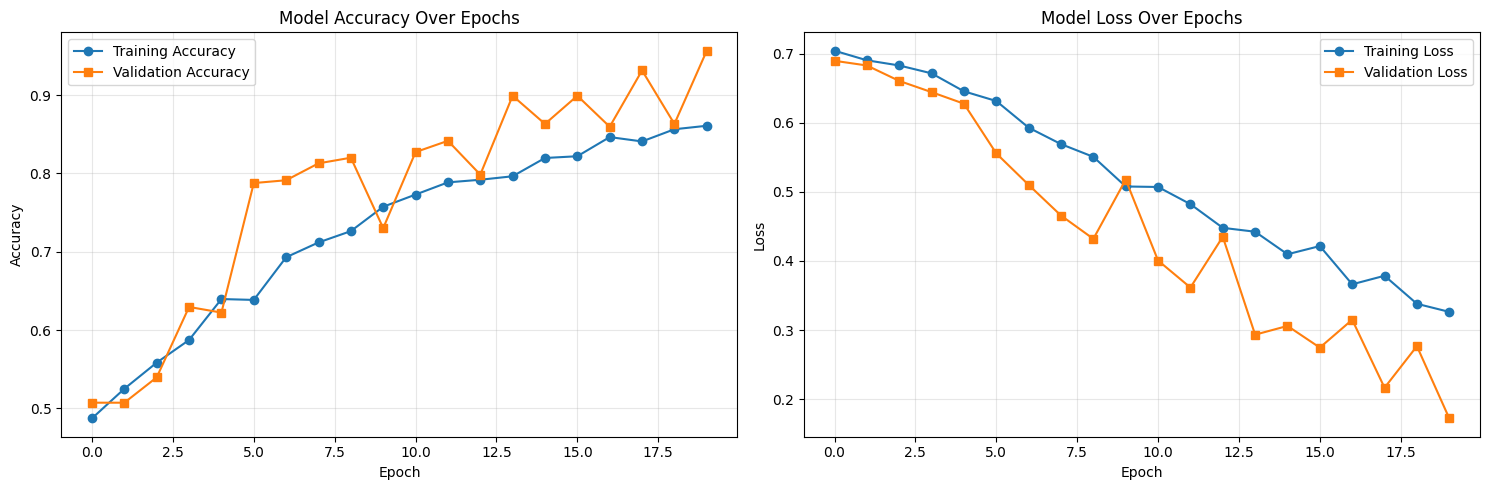

In [11]:
def evaluate_model(name, dataset):
    print(f'valuating {name} set')
    loss, acc = cnn_model.evaluate(dataset, verbose=1)
    print(f'{name} loss: {loss:.4f}')
    print(f'{name} accuracy: {acc:.4f}')
    print(f'Akurasi {name}: {acc*100:.2f}%')
    return loss, acc

train_loss, train_acc = evaluate_model('Training', train_gen)
val_loss, val_acc = evaluate_model('Validation', val_gen)
test_loss, test_acc = evaluate_model('Test', test_gen)


print("\n" + "="*50)
print("KRITERIA AKURASI CHECK:")
print(f"Training Accuracy: {train_acc*100:.2f}% {'✅' if train_acc >= 0.85 else '❌'}")
print(f"Test Accuracy: {test_acc*100:.2f}% {'✅' if test_acc >= 0.85 else '❌'}")
print("="*50)

def visualize_training_history(history, metric_name):
    """Fungsi untuk visualisasi training history"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric_name], label=f'Training {metric_name}', marker='o')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}', marker='s')
    plt.title(f'{metric_name.capitalize()} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True, alpha=0.3)

    return plt

# Plot accuracy and loss
print("Generating training visualizations...")

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
!mkdir models

## Konversi Model

In [25]:
DIR = "models"
os.makedirs(DIR, exist_ok=True)

saved_model_path = os.path.join(DIR, "saved_model")
tf.saved_model.save(cnn_model, saved_model_path)

h5_path = os.path.join(DIR, "model.h5")
cnn_model.save(h5_path, include_optimizer=False, save_format='.h5')

#Konversi ke TensorFlow Lite
tflite_dir = os.path.join(DIR, "tflite")
os.makedirs(tflite_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan model .tflite
with open(os.path.join(tflite_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
labels = list(train_gen.class_indices.keys())
with open(os.path.join(tflite_dir, "label.txt"), "w") as f:
    f.write("\n".join(labels))

print("✅ TFLite model and labels exported.")

#Konversi ke TensorFlow.js
!pip install -q tensorflowjs
tfjs_dir = os.path.join(DIR, "tfjs_model")
!tensorflowjs_converter --input_format=keras "{h5_path}" "{tfjs_dir}"

✅ TFLite model and labels exported.
2025-06-15 09:32:10.250657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749979930.270324   14427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749979930.276232   14427 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749979930.291865   14427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749979930.291892   14427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749979930.291896   14427 computation_p

## Inference (Optional)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step


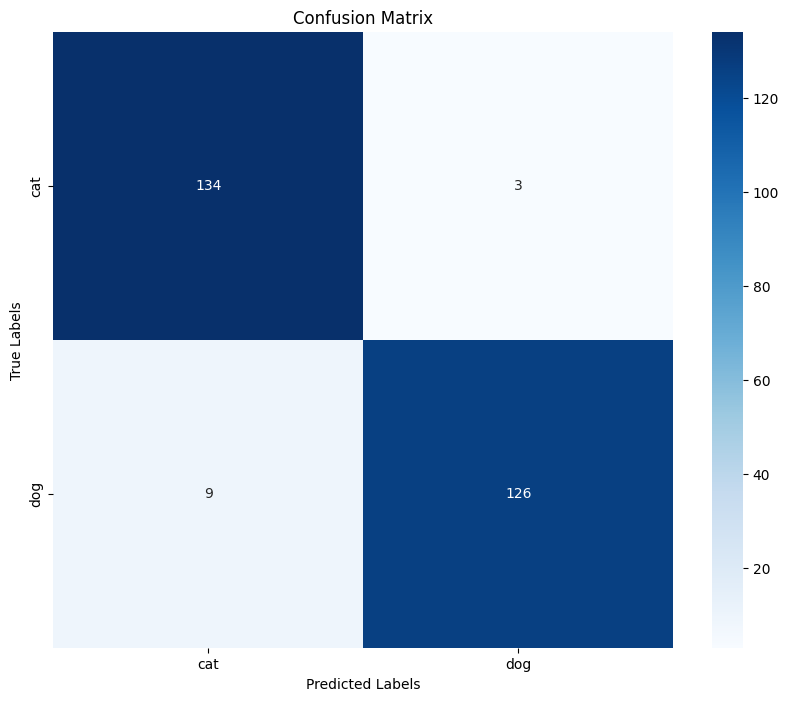


Classification Report:
              precision    recall  f1-score   support

         cat       0.94      0.98      0.96       137
         dog       0.98      0.93      0.95       135

    accuracy                           0.96       272
   macro avg       0.96      0.96      0.96       272
weighted avg       0.96      0.96      0.96       272



In [27]:
predictions = cnn_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_labels))